In [ ]:
# Notebook 02: Построение регрессионных моделей

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Для регрессионного анализа
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tools.tools import add_constant

# Для пошаговых алгоритмов
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [ ]:
# 1. ЗАГРУЗКА ФИНАЛЬНОГО НАБОРА ДАННЫХ

In [30]:
# Загрузка данных после устранения мультиколлинеарности
df_modeling = pd.read_csv('../results/tables/data_for_modeling.csv')

print(f"\nРазмер датасета: {df_modeling.shape[0]} наблюдений x {df_modeling.shape[1]} переменных")
print(f"Переменные: {list(df_modeling.columns)}")

# Разделение на X и Y
y = df_modeling['potras'].copy()
X_vars = ['doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']
X = df_modeling[X_vars].copy()

print(f"\nЗависимая переменная: potras")
print(f"Объясняющие переменные ({len(X_vars)}): {X_vars}")


Размер датасета: 2605 наблюдений x 7 переменных
Переменные: ['potras', 'doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']

Зависимая переменная: potras
Объясняющие переменные (6): ['doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']


In [3]:
# 2. МОДЕЛЬ 0: ИСХОДНАЯ (BASELINE) - ВСЕ ПЕРЕМЕННЫЕ БЕЗ ПРЕОБРАЗОВАНИЙ

In [31]:
print("""
Спецификация:
  potras = β₀ + β₁·doxodsn + β₂·natdox + β₃·nalog + β₄·ssber + 
           β₅·kvzv + β₆·dhpens + ε
           
Описание:
  - Все переменные в исходном виде (без логарифмирования)
  - Все переменные включены в модель
  - Это БАЗОВАЯ модель для сравнения с улучшенными версиями
""")

# Добавление константы
X_baseline = add_constant(X)

# Построение модели
model_0 = sm.OLS(y, X_baseline).fit()

print("\nРЕЗУЛЬТАТЫ МОДЕЛИ 0 (BASELINE):")
print(model_0.summary())

# Сохранение ключевых метрик
metrics_baseline = {
    'Model': 'Baseline (все переменные)',
    'R²': model_0.rsquared,
    'Adj. R²': model_0.rsquared_adj,
    'MSE': mean_squared_error(y, model_0.fittedvalues),
    'RMSE': np.sqrt(mean_squared_error(y, model_0.fittedvalues)),
    'AIC': model_0.aic,
    'BIC': model_0.bic,
    'N_vars': len(X_vars)
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ МОДЕЛИ 0:")
for key, value in metrics_baseline.items():
    if key not in ['Model']:
        print(f"{key:12s}: {value:.4f}")


Спецификация:
  potras = β₀ + β₁·doxodsn + β₂·natdox + β₃·nalog + β₄·ssber + 
           β₅·kvzv + β₆·dhpens + ε

Описание:
  - Все переменные в исходном виде (без логарифмирования)
  - Все переменные включены в модель
  - Это БАЗОВАЯ модель для сравнения с улучшенными версиями


РЕЗУЛЬТАТЫ МОДЕЛИ 0 (BASELINE):
                            OLS Regression Results                            
Dep. Variable:                 potras   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     543.6
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:21:54   Log-Likelihood:                -32278.
No. Observations:                2605   AIC:                         6.457e+04
Df Residuals:                    2598   BIC:                         6.461e+04
Df Model:                           6                 

In [ ]:
# 3. МОДЕЛЬ 1: ПОШАГОВОЕ ИСКЛЮЧЕНИЕ (BACKWARD ELIMINATION)

In [32]:
print("""
Алгоритм:
  1. Начинаем со всех переменных
  2. Удаляем переменную с наибольшим p-value > 0.05
  3. Пересчитываем модель
  4. Повторяем до тех пор, пока все p-values < 0.05
""")

def backward_elimination(X, y, significance_level=0.05):
    """
    Пошаговое исключение переменных
    """
    X_work = X.copy()
    features = list(X_work.columns)
    
    print("\nПроцесс исключения переменных:")
    
    iteration = 0
    while len(features) > 0:
        iteration += 1
        X_temp = add_constant(X_work[features])
        model_temp = sm.OLS(y, X_temp).fit()
        
        # Получаем p-values (исключая константу)
        pvalues = model_temp.pvalues.iloc[1:]
        max_pvalue = pvalues.max()
        
        print(f"\nИтерация {iteration}:")
        print(f"  Переменные в модели: {features}")
        print(f"  Максимальный p-value: {max_pvalue:.4f}")
        
        if max_pvalue > significance_level:
            excluded_feature = pvalues.idxmax()
            print(f"Исключаем: {excluded_feature} (p-value = {max_pvalue:.4f})")
            features.remove(excluded_feature)
        else:
            print(f"Все p-values < {significance_level}. Останавливаемся.")
            break
    
    print(f"ИТОГО: Осталось {len(features)} переменных: {features}")
    
    return features, model_temp

# Запуск backward elimination
features_backward, model_1 = backward_elimination(X, y, significance_level=0.05)

print("\nФИНАЛЬНАЯ МОДЕЛЬ 1 (BACKWARD ELIMINATION):")
print(model_1.summary())

# Метрики
metrics_backward = {
    'Model': 'Backward Elimination',
    'R²': model_1.rsquared,
    'Adj. R²': model_1.rsquared_adj,
    'MSE': mean_squared_error(y, model_1.fittedvalues),
    'RMSE': np.sqrt(mean_squared_error(y, model_1.fittedvalues)),
    'AIC': model_1.aic,
    'BIC': model_1.bic,
    'N_vars': len(features_backward)
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ МОДЕЛИ 1:")
for key, value in metrics_backward.items():
    if key not in ['Model']:
        print(f"{key:12s}: {value:.4f}")



Алгоритм:
  1. Начинаем со всех переменных
  2. Удаляем переменную с наибольшим p-value > 0.05
  3. Пересчитываем модель
  4. Повторяем до тех пор, пока все p-values < 0.05


Процесс исключения переменных:

Итерация 1:
  Переменные в модели: ['doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']
  Максимальный p-value: 0.5969
Исключаем: kvzv (p-value = 0.5969)

Итерация 2:
  Переменные в модели: ['doxodsn', 'natdox', 'nalog', 'ssber', 'dhpens']
  Максимальный p-value: 0.0952
Исключаем: dhpens (p-value = 0.0952)

Итерация 3:
  Переменные в модели: ['doxodsn', 'natdox', 'nalog', 'ssber']
  Максимальный p-value: 0.0041
Все p-values < 0.05. Останавливаемся.
ИТОГО: Осталось 4 переменных: ['doxodsn', 'natdox', 'nalog', 'ssber']

ФИНАЛЬНАЯ МОДЕЛЬ 1 (BACKWARD ELIMINATION):
                            OLS Regression Results                            
Dep. Variable:                 potras   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:       

In [ ]:
# 4. МОДЕЛЬ 2: ПОШАГОВОЕ ВКЛЮЧЕНИЕ (FORWARD SELECTION)

In [33]:
print("""
Алгоритм:
  1. Начинаем с пустой модели (только константа)
  2. Добавляем переменную с наименьшим p-value < 0.05
  3. Пересчитываем модель
  4. Повторяем до тех пор, пока нет переменных с p-value < 0.05
""")

def forward_selection(X, y, significance_level=0.05):
    """
    Пошаговое включение переменных
    """
    initial_features = list(X.columns)
    selected_features = []
    
    print("\nПроцесс включения переменных:")
    
    iteration = 0
    while len(initial_features) > 0:
        iteration += 1
        remaining_features = [f for f in initial_features if f not in selected_features]
        
        if len(remaining_features) == 0:
            break
        
        print(f"\nИтерация {iteration}:")
        print(f"  Текущие переменные: {selected_features if selected_features else 'нет'}")
        print(f"  Кандидаты: {remaining_features}")
        
        best_pvalue = 1.0
        best_feature = None
        
        for feature in remaining_features:
            test_features = selected_features + [feature]
            X_temp = add_constant(X[test_features])
            model_temp = sm.OLS(y, X_temp).fit()
            
            # p-value новой переменной
            pvalue = model_temp.pvalues[feature]
            
            if pvalue < best_pvalue:
                best_pvalue = pvalue
                best_feature = feature
        
        if best_pvalue < significance_level:
            selected_features.append(best_feature)
            print(f"Добавляем: {best_feature} (p-value = {best_pvalue:.4f})")
        else:
            print(f"Лучший кандидат {best_feature} имеет p-value = {best_pvalue:.4f} > {significance_level}")
            print(f"Останавливаемся.")
            break
    
    print(f"\nИТОГО: Выбрано {len(selected_features)} переменных: {selected_features}")

    # Финальная модель
    X_final = add_constant(X[selected_features])
    model_final = sm.OLS(y, X_final).fit()
    
    return selected_features, model_final

# Запуск forward selection
features_forward, model_2 = forward_selection(X, y, significance_level=0.05)

print("\nФИНАЛЬНАЯ МОДЕЛЬ 2 (FORWARD SELECTION):")
print(model_2.summary())

# Метрики
metrics_forward = {
    'Model': 'Forward Selection',
    'R²': model_2.rsquared,
    'Adj. R²': model_2.rsquared_adj,
    'MSE': mean_squared_error(y, model_2.fittedvalues),
    'RMSE': np.sqrt(mean_squared_error(y, model_2.fittedvalues)),
    'AIC': model_2.aic,
    'BIC': model_2.bic,
    'N_vars': len(features_forward)
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ МОДЕЛИ 2:")
for key, value in metrics_forward.items():
    if key not in ['Model']:
        print(f"{key:12s}: {value:.4f}")


Алгоритм:
  1. Начинаем с пустой модели (только константа)
  2. Добавляем переменную с наименьшим p-value < 0.05
  3. Пересчитываем модель
  4. Повторяем до тех пор, пока нет переменных с p-value < 0.05


Процесс включения переменных:

Итерация 1:
  Текущие переменные: нет
  Кандидаты: ['doxodsn', 'natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']
Добавляем: doxodsn (p-value = 0.0000)

Итерация 2:
  Текущие переменные: ['doxodsn']
  Кандидаты: ['natdox', 'nalog', 'ssber', 'kvzv', 'dhpens']
Добавляем: ssber (p-value = 0.0000)

Итерация 3:
  Текущие переменные: ['doxodsn', 'ssber']
  Кандидаты: ['natdox', 'nalog', 'kvzv', 'dhpens']
Добавляем: nalog (p-value = 0.0021)

Итерация 4:
  Текущие переменные: ['doxodsn', 'ssber', 'nalog']
  Кандидаты: ['natdox', 'kvzv', 'dhpens']
Добавляем: natdox (p-value = 0.0041)

Итерация 5:
  Текущие переменные: ['doxodsn', 'ssber', 'nalog', 'natdox']
  Кандидаты: ['kvzv', 'dhpens']
Лучший кандидат dhpens имеет p-value = 0.0952 > 0.05
Останавливаемся.

ИТОГО: В

In [ ]:
# 5. СРАВНЕНИЕ МОДЕЛЕЙ 0, 1, 2


                                  R²   Adj. R²           MSE          RMSE  \
Model                                                                       
Baseline (все переменные)  0.556624  0.555600  3.388766e+09  58213.104924   
Backward Elimination       0.556100  0.555418  3.392764e+09  58247.435923   
Forward Selection          0.556100  0.555418  3.392764e+09  58247.435923   

                                    AIC           BIC  N_vars  
Model                                                          
Baseline (все переменные)  64570.090466  64611.146782       6  
Backward Elimination       64569.162142  64598.488082       4  
Forward Selection          64569.162142  64598.488082       4  


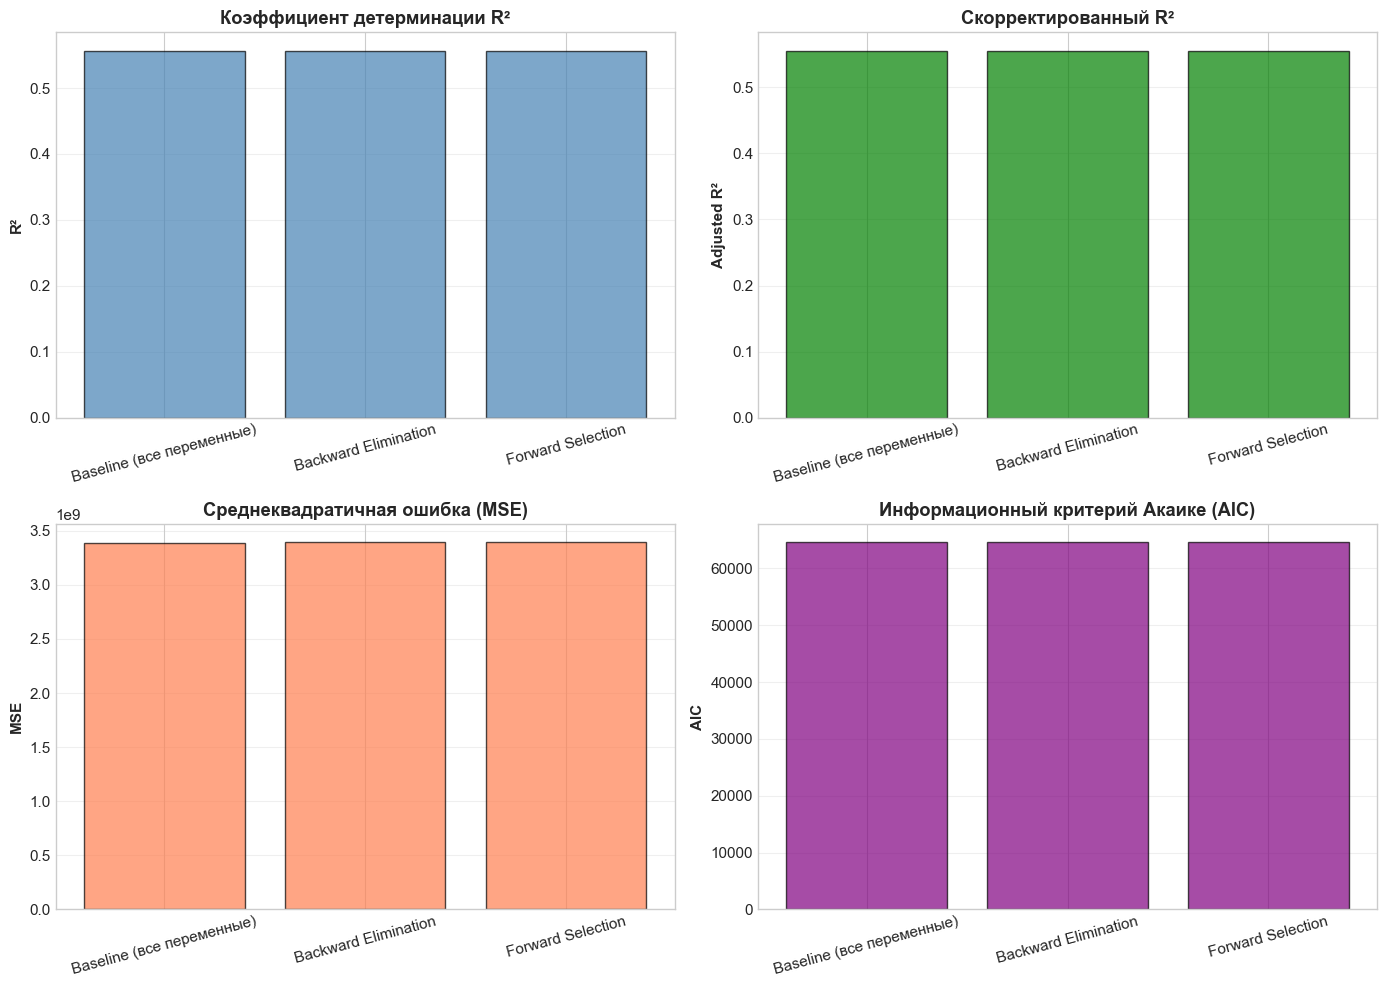


График сравнения сохранен: models_comparison_step1.png

ВЫБОР ЛУЧШЕЙ МОДЕЛИ ИЗ ПОШАГОВЫХ АЛГОРИТМОВ

Лучшая модель по Adj. R²: Backward Elimination
  R² = 0.5561
  Adj. R² = 0.5554
  MSE = 3392763791.6316

Таблица сравнения сохранена: models_comparison_step1.csv


In [34]:
comparison_df = pd.DataFrame([metrics_baseline, metrics_backward, metrics_forward])
comparison_df = comparison_df.set_index('Model')

print("\n", comparison_df)

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R²
axes[0, 0].bar(comparison_df.index, comparison_df['R²'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('R²', fontweight='bold')
axes[0, 0].set_title('Коэффициент детерминации R²', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=15)

# Adj R²
axes[0, 1].bar(comparison_df.index, comparison_df['Adj. R²'], color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Adjusted R²', fontweight='bold')
axes[0, 1].set_title('Скорректированный R²', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=15)

# MSE
axes[1, 0].bar(comparison_df.index, comparison_df['MSE'], color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('MSE', fontweight='bold')
axes[1, 0].set_title('Среднеквадратичная ошибка (MSE)', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=15)

# AIC
axes[1, 1].bar(comparison_df.index, comparison_df['AIC'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('AIC', fontweight='bold')
axes[1, 1].set_title('Информационный критерий Акаике (AIC)', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../results/figures/models_comparison_step1.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафик сравнения сохранен: models_comparison_step1.png")

# Выбор лучшей модели из пошаговых
print("\nВЫБОР ЛУЧШЕЙ МОДЕЛИ ИЗ ПОШАГОВЫХ АЛГОРИТМОВ")

best_idx = comparison_df['Adj. R²'].iloc[1:].idxmax()  # Исключаем baseline
print(f"\nЛучшая модель по Adj. R²: {best_idx}")
print(f"  R² = {comparison_df.loc[best_idx, 'R²']:.4f}")
print(f"  Adj. R² = {comparison_df.loc[best_idx, 'Adj. R²']:.4f}")
print(f"  MSE = {comparison_df.loc[best_idx, 'MSE']:.4f}")

# Сохранение результатов
comparison_df.to_csv('../results/tables/models_comparison_step1.csv')
print("\nТаблица сравнения сохранена: models_comparison_step1.csv")

In [ ]:
# 6. МОДЕЛИ С ЛОГАРИФМИРОВАНИЕМ

In [35]:
print("""
Будут построены следующие модели:
  3. log(Y) ~ X (логарифм зависимой переменной)
  4. Y ~ log(X) (логарифмы объясняющих переменных)
  5. log(Y) ~ log(X) (логарифмы обеих сторон)
  
Используем переменные, выбранные лучшим пошаговым алгоритмом.
""")

# Определяем переменные для логарифмических моделей
# Используем переменные из лучшей пошаговой модели
if best_idx == 'Backward Elimination':
    selected_vars = features_backward
    best_stepwise_model = model_1
else:
    selected_vars = features_forward
    best_stepwise_model = model_2

print(f"\nПеременные для логарифмических моделей: {selected_vars}")

# Подготовка данных
# Для логарифмирования нужны только положительные значения
# Проверим переменные

print("\nПроверка переменных на возможность логарифмирования:")

log_vars = []
for var in selected_vars:
    min_val = X[var].min()
    has_negative = (X[var] <= 0).any()
    
    if has_negative:
        print(f"  {var:12s}: Содержит неположительные значения (min = {min_val:.2f})")
    else:
        print(f"  {var:12s}: Все значения положительные (min = {min_val:.2f})")
        if var != 'dhpens':  # Не логарифмируем бинарную переменную
            log_vars.append(var)

print(f"\nПеременные для логарифмирования: {log_vars}")


Будут построены следующие модели:
  3. log(Y) ~ X (логарифм зависимой переменной)
  4. Y ~ log(X) (логарифмы объясняющих переменных)
  5. log(Y) ~ log(X) (логарифмы обеих сторон)

Используем переменные, выбранные лучшим пошаговым алгоритмом.


Переменные для логарифмических моделей: ['doxodsn', 'natdox', 'nalog', 'ssber']

Проверка переменных на возможность логарифмирования:
  doxodsn     : Все значения положительные (min = 24668.43)
  natdox      : Содержит неположительные значения (min = 0.00)
  nalog       : Содержит неположительные значения (min = 0.00)
  ssber       : Содержит неположительные значения (min = 0.00)

Переменные для логарифмирования: ['doxodsn']


In [9]:
# МОДЕЛЬ 3: log(Y) ~ X

In [36]:
# Логарифм Y
y_log = np.log(y)

X_model3 = add_constant(X[selected_vars])
model_3 = sm.OLS(y_log, X_model3).fit()

print(model_3.summary())

# Предсказания в исходной шкале
y_pred_log = model_3.fittedvalues
y_pred_3 = np.exp(y_pred_log)

# Метрики в исходной шкале
metrics_log_y = {
    'Model': 'log(Y) ~ X',
    'R²': r2_score(y, y_pred_3),
    'Adj. R²': model_3.rsquared_adj,  # в логарифмической шкале
    'MSE': mean_squared_error(y, y_pred_3),
    'RMSE': np.sqrt(mean_squared_error(y, y_pred_3)),
    'AIC': model_3.aic,
    'BIC': model_3.bic,
    'N_vars': len(selected_vars)
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ МОДЕЛИ 3 (в исходной шкале Y):")
for key, value in metrics_log_y.items():
    if key not in ['Model']:
        print(f"{key:12s}: {value:.4f}")

                            OLS Regression Results                            
Dep. Variable:                 potras   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     1441.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:22:18   Log-Likelihood:                -486.16
No. Observations:                2605   AIC:                             982.3
Df Residuals:                    2600   BIC:                             1012.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7006      0.011    971.609      0.0

In [ ]:
# МОДЕЛЬ 4: Y ~ log(X)

In [37]:
# Создаем логарифмы X
X_logged = X[log_vars].copy()
for var in log_vars:
    X_logged[f'log_{var}'] = np.log(X[var])

# Если есть бинарная переменная, добавляем ее без логарифма
if 'dhpens' in selected_vars:
    X_logged['dhpens'] = X['dhpens']

# Строим модель
log_x_vars = [f'log_{var}' for var in log_vars]
if 'dhpens' in selected_vars:
    log_x_vars.append('dhpens')

X_model4 = add_constant(X_logged[log_x_vars])
model_4 = sm.OLS(y, X_model4).fit()

print(model_4.summary())

# Метрики
metrics_log_x = {
    'Model': 'Y ~ log(X)',
    'R²': model_4.rsquared,
    'Adj. R²': model_4.rsquared_adj,
    'MSE': mean_squared_error(y, model_4.fittedvalues),
    'RMSE': np.sqrt(mean_squared_error(y, model_4.fittedvalues)),
    'AIC': model_4.aic,
    'BIC': model_4.bic,
    'N_vars': len(log_x_vars)
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ МОДЕЛИ 4:")
for key, value in metrics_log_x.items():
    if key not in ['Model']:
        print(f"{key:12s}: {value:.4f}")

                            OLS Regression Results                            
Dep. Variable:                 potras   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     1868.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):          4.51e-308
Time:                        23:22:21   Log-Likelihood:                -32633.
No. Observations:                2605   AIC:                         6.527e+04
Df Residuals:                    2603   BIC:                         6.528e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.125e+06   2.85e+04    -39.532      

In [ ]:
# МОДЕЛЬ 5: log(Y) ~ log(X)

In [38]:
X_model5 = add_constant(X_logged[log_x_vars])
model_5 = sm.OLS(y_log, X_model5).fit()

print(model_5.summary())

# Предсказания в исходной шкале
y_pred_log5 = model_5.fittedvalues
y_pred_5 = np.exp(y_pred_log5)

# Метрики в исходной шкале
metrics_log_both = {
    'Model': 'log(Y) ~ log(X)',
    'R²': r2_score(y, y_pred_5),
    'Adj. R²': model_5.rsquared_adj,  # в логарифмической шкале
    'MSE': mean_squared_error(y, y_pred_5),
    'RMSE': np.sqrt(mean_squared_error(y, y_pred_5)),
    'AIC': model_5.aic,
    'BIC': model_5.bic,
    'N_vars': len(log_x_vars)
}

print("\nКЛЮЧЕВЫЕ МЕТРИКИ МОДЕЛИ 5 (в исходной шкале Y):")
for key, value in metrics_log_both.items():
    if key not in ['Model']:
        print(f"{key:12s}: {value:.4f}")

                            OLS Regression Results                            
Dep. Variable:                 potras   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 1.321e+04
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:22:24   Log-Likelihood:                 341.78
No. Observations:                2605   AIC:                            -679.6
Df Residuals:                    2603   BIC:                            -667.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9982      0.091     11.022      

In [ ]:
# 7. СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (0-5)


                                   R²   Adj. R²           MSE           RMSE  \
Model                                                                         
Baseline (все переменные)   0.556624  0.555600  3.388766e+09   58213.104924   
Backward Elimination        0.556100  0.555418  3.392764e+09   58247.435923   
Forward Selection           0.556100  0.555418  3.392764e+09   58247.435923   
log(Y) ~ X                -27.263010  0.688663  2.160167e+11  464775.963373   
Y ~ log(X)                  0.417770  0.417546  4.450037e+09   66708.600653   
log(Y) ~ log(X)             0.527125  0.835309  3.614225e+09   60118.420863   

                                    AIC           BIC  N_vars  
Model                                                          
Baseline (все переменные)  64570.090466  64611.146782       6  
Backward Elimination       64569.162142  64598.488082       4  
Forward Selection          64569.162142  64598.488082       4  
log(Y) ~ X                   982.320355   101

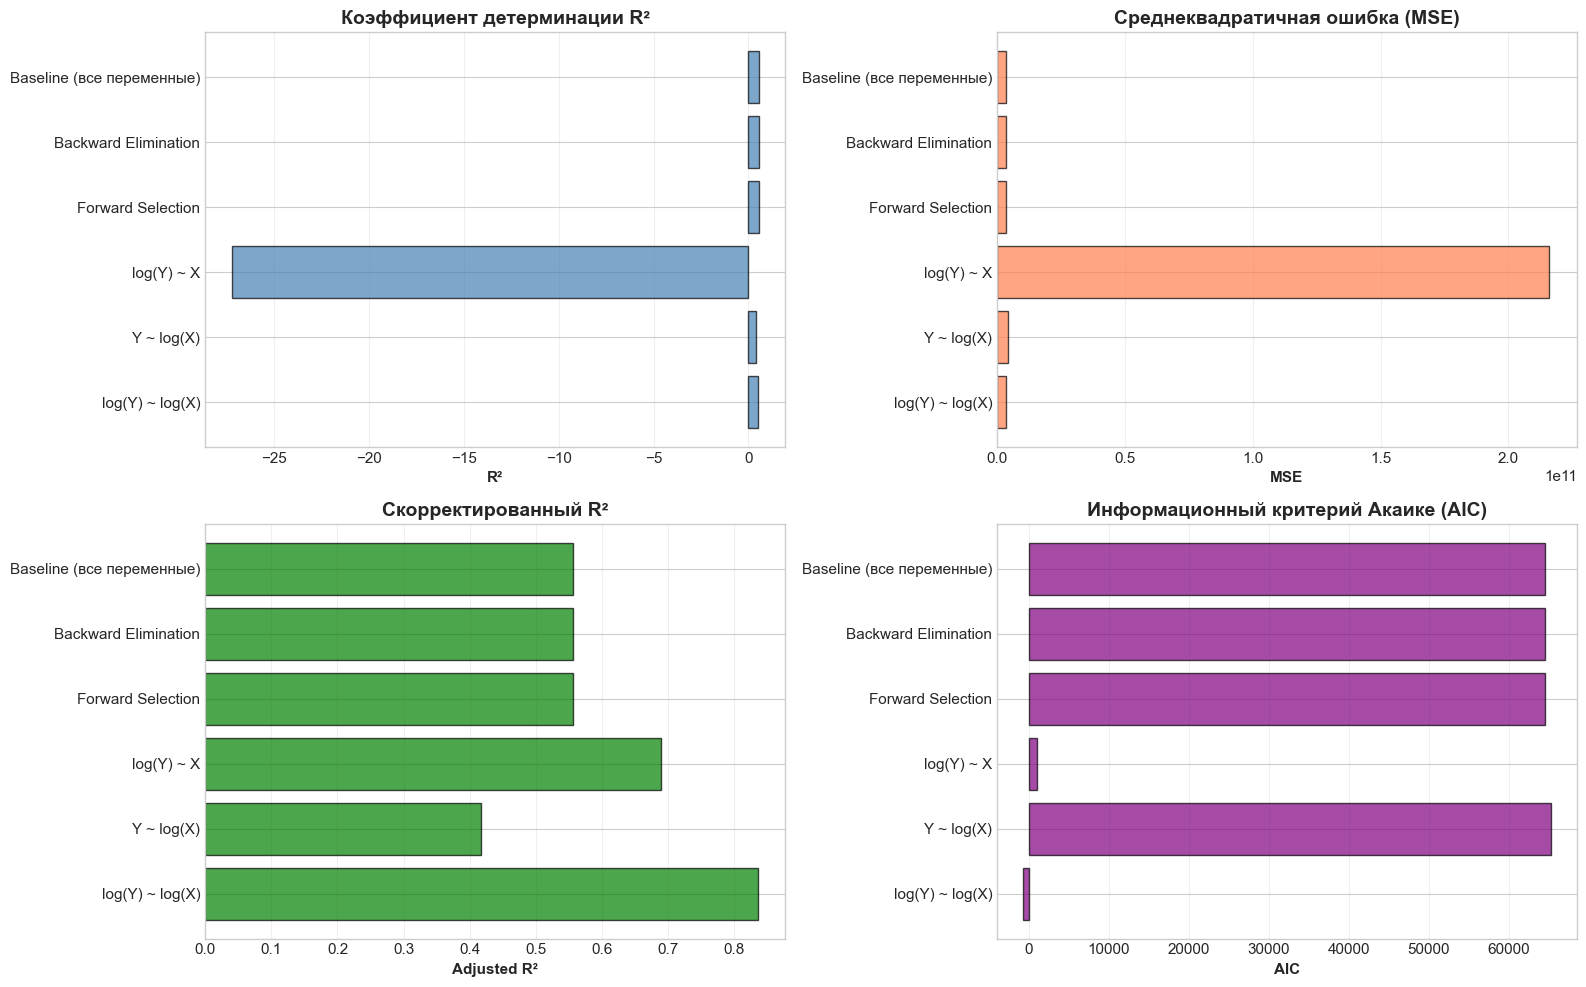


График сравнения всех моделей сохранен: all_models_comparison.png
Таблица сравнения сохранена: all_models_comparison.csv


In [39]:
all_metrics = pd.DataFrame([
    metrics_baseline,
    metrics_backward,
    metrics_forward,
    metrics_log_y,
    metrics_log_x,
    metrics_log_both
])
all_metrics = all_metrics.set_index('Model')

print("\n", all_metrics)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# R²
axes[0, 0].barh(all_metrics.index, all_metrics['R²'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('R²', fontweight='bold')
axes[0, 0].set_title('Коэффициент детерминации R²', fontweight='bold', fontsize=14)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# MSE
axes[0, 1].barh(all_metrics.index, all_metrics['MSE'], color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('MSE', fontweight='bold')
axes[0, 1].set_title('Среднеквадратичная ошибка (MSE)', fontweight='bold', fontsize=14)
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# Adj R²
axes[1, 0].barh(all_metrics.index, all_metrics['Adj. R²'], color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Adjusted R²', fontweight='bold')
axes[1, 0].set_title('Скорректированный R²', fontweight='bold', fontsize=14)
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

# AIC
axes[1, 1].barh(all_metrics.index, all_metrics['AIC'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('AIC', fontweight='bold')
axes[1, 1].set_title('Информационный критерий Акаике (AIC)', fontweight='bold', fontsize=14)
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('../results/figures/all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафик сравнения всех моделей сохранен: all_models_comparison.png")

# Сохранение таблицы
all_metrics.to_csv('../results/tables/all_models_comparison.csv')
print("Таблица сравнения сохранена: all_models_comparison.csv")

In [ ]:
# 8. ВЫБОР ЛУЧШЕЙ МОДЕЛИ

In [40]:
# Исключаем baseline для выбора лучшей
models_excl_baseline = all_metrics.iloc[1:]

# Критерии выбора
best_r2 = models_excl_baseline['R²'].idxmax()
best_mse = models_excl_baseline['MSE'].idxmin()
best_aic = models_excl_baseline['AIC'].idxmin()

print(f"\nЛучшая по R²: {best_r2} (R² = {models_excl_baseline.loc[best_r2, 'R²']:.4f})")
print(f"Лучшая по MSE: {best_mse} (MSE = {models_excl_baseline.loc[best_mse, 'MSE']:.4f})")
print(f"Лучшая по AIC: {best_aic} (AIC = {models_excl_baseline.loc[best_aic, 'AIC']:.4f})")

# Выбираем модель с лучшим балансом
print("\nИТОГОВЫЙ ВЫБОР:")

# Обычно выбираем модель с наилучшим MSE при приемлемом R²
best_model_name = best_mse
best_model_metrics = all_metrics.loc[best_model_name]

print(f"\nВыбрана модель: {best_model_name}")
print(f"\nХарактеристики:")
for key, value in best_model_metrics.items():
    print(f"  {key:12s}: {value}")

# Определяем объект модели
if best_model_name == 'Backward Elimination':
    best_model_obj = model_1
elif best_model_name == 'Forward Selection':
    best_model_obj = model_2
elif best_model_name == 'log(Y) ~ X':
    best_model_obj = model_3
elif best_model_name == 'Y ~ log(X)':
    best_model_obj = model_4
else:  # 'log(Y) ~ log(X)'
    best_model_obj = model_5

print("\nЭТАП 1 ЗАВЕРШЕН: Модели построены, лучшая модель выбрана")
print(f"\nДалее: Проверка гетероскедастичности для модели '{best_model_name}'")


Лучшая по R²: Backward Elimination (R² = 0.5561)
Лучшая по MSE: Backward Elimination (MSE = 3392763791.6316)
Лучшая по AIC: log(Y) ~ log(X) (AIC = -679.5557)

ИТОГОВЫЙ ВЫБОР:

Выбрана модель: Backward Elimination

Характеристики:
  R²          : 0.55610043418464
  Adj. R²     : 0.5554175117756932
  MSE         : 3392763791.631607
  RMSE        : 58247.43592323706
  AIC         : 64569.16214178038
  BIC         : 64598.488081551324
  N_vars      : 4.0

ЭТАП 1 ЗАВЕРШЕН: Модели построены, лучшая модель выбрана

Далее: Проверка гетероскедастичности для модели 'Backward Elimination'


In [ ]:
# 9. АНАЛИЗ ОСТАТКОВ И ГЕТЕРОСКЕДАСТИЧНОСТИ

In [41]:
print(f"""
Анализируем модель: '{best_model_name}'

Гетероскедастичность - это неоднородность дисперсии остатков.
Признаки гетероскедастичности:
    Остатки растут/падают с увеличением предсказанных значений
    "Воронкообразное" расширение облака точек в графике остатков
    Статистическая значимость в тестах Бройша-Пагана или Уайта
""")

# Получение остатков и предсказанных значений
residuals = best_model_obj.resid
fitted_values = best_model_obj.fittedvalues


Анализируем модель: 'Backward Elimination'

Гетероскедастичность - это неоднородность дисперсии остатков.
Признаки гетероскедастичности:
    Остатки растут/падают с увеличением предсказанных значений
    "Воронкообразное" расширение облака точек в графике остатков
    Статистическая значимость в тестах Бройша-Пагана или Уайта



In [ ]:
# 9.1. ГРАФИЧЕСКИЙ АНАЛИЗ ОСТАТКОВ

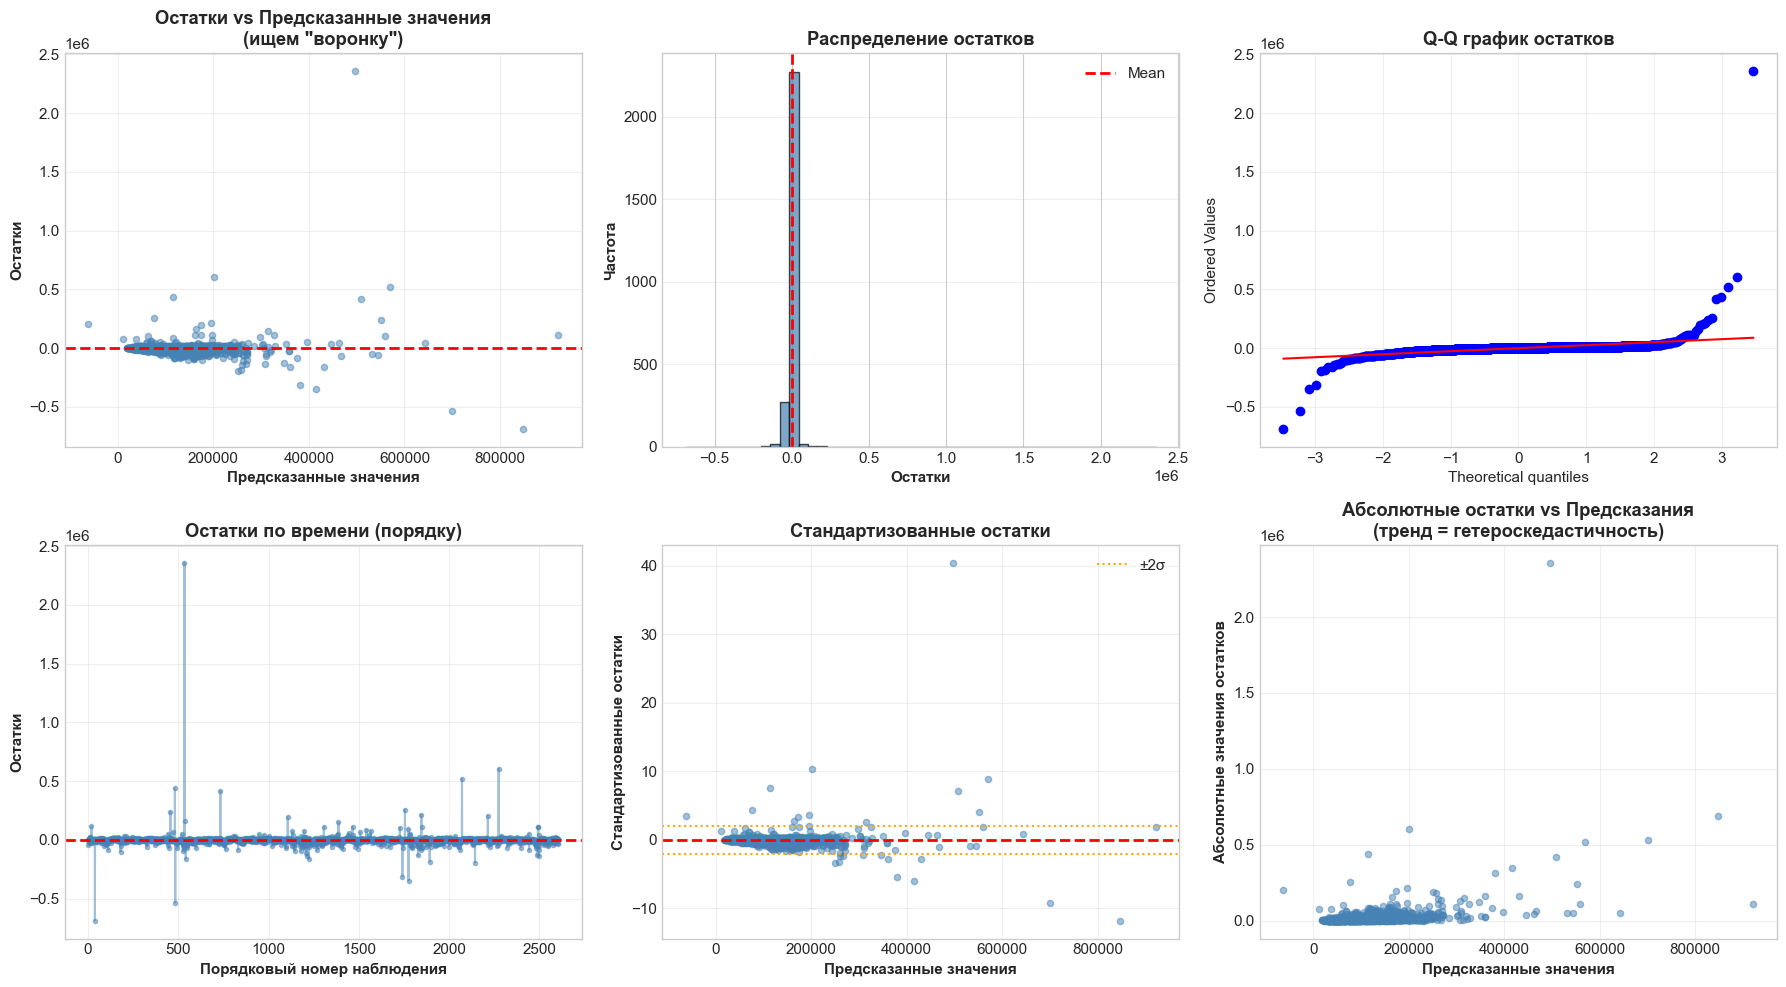


Графики анализа остатков сохранены: residuals_analysis.png

ВИЗУАЛЬНАЯ ИНТЕРПРЕТАЦИЯ:

Признаки гетероскедастичности (на графике 1):
    Облако точек напоминает "воронку" (расширяется)
    Разброс остатков растет с увеличением предсказанных значений
    На графике 6 видна четкая тенденция (линия, кривая)

Признаки гомоскедастичности (нет проблемы):
    Облако точек примерно одинаково разреженное везде
    Остатки равномерно распределены вокруг нуля
    На графике 6 нет четкого тренда



In [42]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Остатки vs Предсказанные значения
axes[0, 0].scatter(fitted_values, residuals, alpha=0.5, s=20, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Предсказанные значения', fontweight='bold')
axes[0, 0].set_ylabel('Остатки', fontweight='bold')
axes[0, 0].set_title('Остатки vs Предсказанные значения\n(ищем "воронку")', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма остатков
axes[0, 1].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].set_xlabel('Остатки', fontweight='bold')
axes[0, 1].set_ylabel('Частота', fontweight='bold')
axes[0, 1].set_title('Распределение остатков', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q график остатков', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 4. Остатки vs Порядковый номер
axes[1, 0].plot(residuals.values, marker='o', linestyle='-', alpha=0.5, markersize=3, color='steelblue')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Порядковый номер наблюдения', fontweight='bold')
axes[1, 0].set_ylabel('Остатки', fontweight='bold')
axes[1, 0].set_title('Остатки по времени (порядку)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 5. Стандартизованные остатки
standardized_residuals = residuals / residuals.std()
axes[1, 1].scatter(fitted_values, standardized_residuals, alpha=0.5, s=20, color='steelblue')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle=':', linewidth=1.5, label='±2σ')
axes[1, 1].axhline(y=-2, color='orange', linestyle=':', linewidth=1.5)
axes[1, 1].set_xlabel('Предсказанные значения', fontweight='bold')
axes[1, 1].set_ylabel('Стандартизованные остатки', fontweight='bold')
axes[1, 1].set_title('Стандартизованные остатки', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Абсолютные остатки vs Предсказанные значения
axes[1, 2].scatter(fitted_values, np.abs(residuals), alpha=0.5, s=20, color='steelblue')
axes[1, 2].set_xlabel('Предсказанные значения', fontweight='bold')
axes[1, 2].set_ylabel('Абсолютные значения остатков', fontweight='bold')
axes[1, 2].set_title('Абсолютные остатки vs Предсказания\n(тренд = гетероскедастичность)', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/residuals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафики анализа остатков сохранены: residuals_analysis.png")

# Визуальная интерпретация
print("\nВИЗУАЛЬНАЯ ИНТЕРПРЕТАЦИЯ:")
print("""
Признаки гетероскедастичности (на графике 1):
    Облако точек напоминает "воронку" (расширяется)
    Разброс остатков растет с увеличением предсказанных значений
    На графике 6 видна четкая тенденция (линия, кривая)

Признаки гомоскедастичности (нет проблемы):
    Облако точек примерно одинаково разреженное везде
    Остатки равномерно распределены вокруг нуля
    На графике 6 нет четкого тренда
""")

In [ ]:
# 9.2. ОПРЕДЕЛЕНИЕ ПЕРЕМЕННЫХ, ВЛИЯЮЩИХ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ


Переменные в модели: ['doxodsn', 'natdox', 'nalog', 'ssber']

Анализ влияния каждой переменной на остатки:


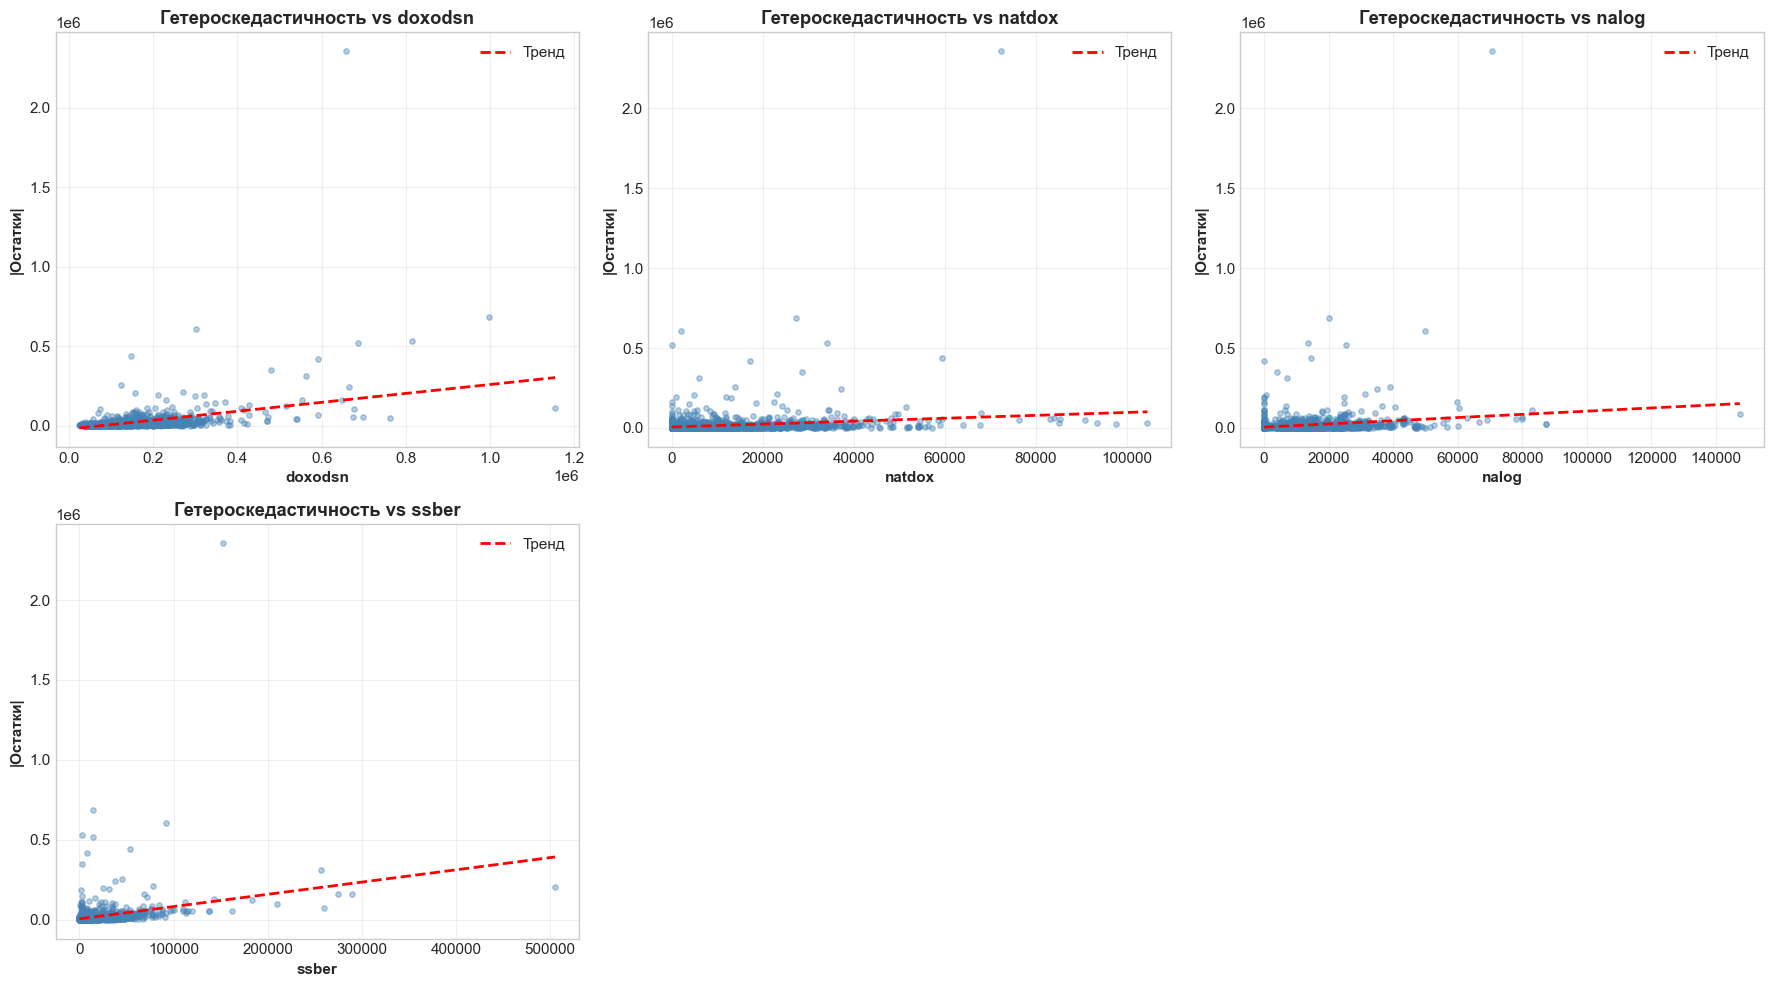


Графики влияния переменных сохранены: heteroscedasticity_by_variables.png


In [43]:
# Определяем переменные, которые были использованы в модели
if best_model_name == 'Backward Elimination':
    model_vars = features_backward
    model_obj = model_1
elif best_model_name == 'Forward Selection':
    model_vars = features_forward
    model_obj = model_2
elif best_model_name == 'log(Y) ~ X':
    model_vars = selected_vars
    model_obj = model_3
elif best_model_name == 'Y ~ log(X)':
    model_vars = log_x_vars
    model_obj = model_4
else:  # 'log(Y) ~ log(X)'
    model_vars = log_x_vars
    model_obj = model_5

print(f"\nПеременные в модели: {model_vars}\n")

# Для моделей с логарифмами обрабатываем названия
actual_x_vars = []
for var in model_vars:
    if var.startswith('log_'):
        actual_x_vars.append(var.replace('log_', ''))
    else:
        actual_x_vars.append(var)

# Анализ влияния каждой переменной на гетероскедастичность
print("Анализ влияния каждой переменной на остатки:")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, var in enumerate(actual_x_vars[:6]):  # Максимум 6 графиков
    if var in X.columns:
        axes[i].scatter(X[var], np.abs(residuals), alpha=0.4, s=15, color='steelblue')
        
        # Добавляем линию тренда для проверки паттерна
        z = np.polyfit(X[var], np.abs(residuals), 1)
        p = np.poly1d(z)
        x_trend = np.linspace(X[var].min(), X[var].max(), 100)
        axes[i].plot(x_trend, p(x_trend), 'r--', linewidth=2, label='Тренд')

        axes[i].set_xlabel(f'{var}', fontweight='bold')
        axes[i].set_ylabel('|Остатки|', fontweight='bold')
        axes[i].set_title(f'Гетероскедастичность vs {var}', fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# Удалить лишние оси
for j in range(len(actual_x_vars[:6]), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../results/figures/heteroscedasticity_by_variables.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафики влияния переменных сохранены: heteroscedasticity_by_variables.png")

In [ ]:
# 9.3. ТЕСТ БРОЙША-ПАГАНА

In [44]:
print("""
Нулевая гипотеза (H₀): Дисперсия остатков одинакова (гомоскедастичность)
Альтернативная гипотеза (H₁): Дисперсия остатков неоднородна (гетероскедастичность)

Интерпретация:
  p-value > 0.05: Не отвергаем H₀ → гомоскедастичность ✓
  p-value < 0.05: Отвергаем H₀ → гетероскедастичность ✗
""")

# Тест Бройша-Пагана
bp_test = het_breuschpagan(residuals, best_model_obj.model.exog)

print(f"\nРезультаты теста Бройша-Пагана:")
print(f"  LM Statistic: {bp_test[0]:.4f}")
print(f"  LM Test p-value: {bp_test[1]:.4f}")
print(f"  F-Statistic: {bp_test[2]:.4f}")
print(f"  F-Test p-value: {bp_test[3]:.4f}")

if bp_test[1] < 0.05:
    print(f"\nВЫВОД: p-value = {bp_test[1]:.4f} < 0.05")
    print("Обнаружена ГЕТЕРОСКЕДАСТИЧНОСТЬ (дисперсия неоднородна)")
    has_heteroscedasticity = True
else:
    print(f"\nВЫВОД: p-value = {bp_test[1]:.4f} > 0.05")
    print("Гетероскедастичность НЕ обнаружена (дисперсия однородна)")
    has_heteroscedasticity = False


Нулевая гипотеза (H₀): Дисперсия остатков одинакова (гомоскедастичность)
Альтернативная гипотеза (H₁): Дисперсия остатков неоднородна (гетероскедастичность)

Интерпретация:
  p-value > 0.05: Не отвергаем H₀ → гомоскедастичность ✓
  p-value < 0.05: Отвергаем H₀ → гетероскедастичность ✗


Результаты теста Бройша-Пагана:
  LM Statistic: 104.9366
  LM Test p-value: 0.0000
  F-Statistic: 27.2828
  F-Test p-value: 0.0000

ВЫВОД: p-value = 0.0000 < 0.05
Обнаружена ГЕТЕРОСКЕДАСТИЧНОСТЬ (дисперсия неоднородна)


In [ ]:
# 9.4. ТЕСТ УАЙТА

In [45]:
print("""
Нулевая гипотеза (H₀): Гомоскедастичность (дисперсия одинакова)
Альтернативная гипотеза (H₁): Гетероскедастичность

Тест Уайта более чувствителен к различным формам гетероскедастичности,
чем тест Бройша-Пагана.

Интерпретация:
  p-value > 0.05: Гомоскедастичность
  p-value < 0.05: Гетероскедастичность
""")

# Тест Уайта
white_test = het_white(residuals, best_model_obj.model.exog)

print(f"\nРезультаты теста Уайта:")
print(f"  LM Statistic: {white_test[0]:.4f}")
print(f"  LM Test p-value: {white_test[1]:.4f}")
print(f"  F-Statistic: {white_test[2]:.4f}")
print(f"  F-Test p-value: {white_test[3]:.4f}")

if white_test[1] < 0.05:
    print(f"\nВЫВОД: p-value = {white_test[1]:.4f} < 0.05")
    print("Обнаружена ГЕТЕРОСКЕДАСТИЧНОСТЬ")
    has_heteroscedasticity_white = True
else:
    print(f"\nВЫВОД: p-value = {white_test[1]:.4f} > 0.05")
    print("Гетероскедастичность НЕ обнаружена")
    has_heteroscedasticity_white = False


Нулевая гипотеза (H₀): Гомоскедастичность (дисперсия одинакова)
Альтернативная гипотеза (H₁): Гетероскедастичность

Тест Уайта более чувствителен к различным формам гетероскедастичности,
чем тест Бройша-Пагана.

Интерпретация:
  p-value > 0.05: Гомоскедастичность
  p-value < 0.05: Гетероскедастичность


Результаты теста Уайта:
  LM Statistic: 526.7019
  LM Test p-value: 0.0000
  F-Statistic: 46.8844
  F-Test p-value: 0.0000

ВЫВОД: p-value = 0.0000 < 0.05
Обнаружена ГЕТЕРОСКЕДАСТИЧНОСТЬ


In [ ]:
# 9.5. ИТОГОВЫЙ ВЫВОД О ГЕТЕРОСКЕДАСТИЧНОСТИ

In [46]:
if has_heteroscedasticity or has_heteroscedasticity_white:
    print(f"""
ОБНАРУЖЕНА ГЕТЕРОСКЕДАСТИЧНОСТЬ:
    Тест Бройша-Пагана: p-value = {bp_test[1]:.4f} {'✗' if bp_test[1] < 0.05 else '✓'}
    Тест Уайта: p-value = {white_test[1]:.4f} {'✗' if white_test[1] < 0.05 else '✓'}

СЛЕДУЮЩИЙ ШАГ:
Применяем поправку Уайта (robust standard errors) для коррекции.
Это позволит получить корректные стандартные ошибки даже при наличии
гетероскедастичности.
""")
else:
    print(f"""
ГЕТЕРОСКЕДАСТИЧНОСТЬ НЕ ОБНАРУЖЕНА:
    Тест Бройша-Пагана: p-value = {bp_test[1]:.4f}
    Тест Уайта: p-value = {white_test[1]:.4f}

ВЫВОД:
Остатки имеют однородную дисперсию. Поправка Уайта не требуется,
но может применяться в целях повышения надежности оценок.
""")


ОБНАРУЖЕНА ГЕТЕРОСКЕДАСТИЧНОСТЬ:
    Тест Бройша-Пагана: p-value = 0.0000 ✗
    Тест Уайта: p-value = 0.0000 ✗

СЛЕДУЮЩИЙ ШАГ:
Применяем поправку Уайта (robust standard errors) для коррекции.
Это позволит получить корректные стандартные ошибки даже при наличии
гетероскедастичности.



In [ ]:
# 10. ПОПРАВКА УАЙТА (ROBUST STANDARD ERRORS)


Поправка Уайта (HC3 - Huber-White sandwich estimator):
    Корректирует стандартные ошибки коэффициентов
    Делает t-статистики и p-values надежными при гетероскедастичности
    НЕ меняет коэффициенты регрессии, только их стандартные ошибки

Типы поправок:
  HC0 - классическая поправка Уайта
  HC1 - поправка с малыми выборками
  HC3 - рекомендуется для малых выборок (используем эту)


СРАВНЕНИЕ: Исходные vs Робастные (HC3) стандартные ошибки

          Коэффициент  Ст.ош (исходн.)  Ст.ош (HC3)  t-stat (исходн.)  \
const     -1816.6622        2199.7773   10982.4909           -0.8258   
doxodsn       0.8572           0.0193       0.0934           44.4672   
natdox        0.3004           0.1044       0.3431            2.8765   
nalog        -0.3929           0.1254       0.3514           -3.1321   
ssber        -0.3879           0.0567       0.2480           -6.8464   

         t-stat (HC3)  p-value (исходн.)  p-value (HC3)  
const         -0.1654             0.4090         0.8686  
d

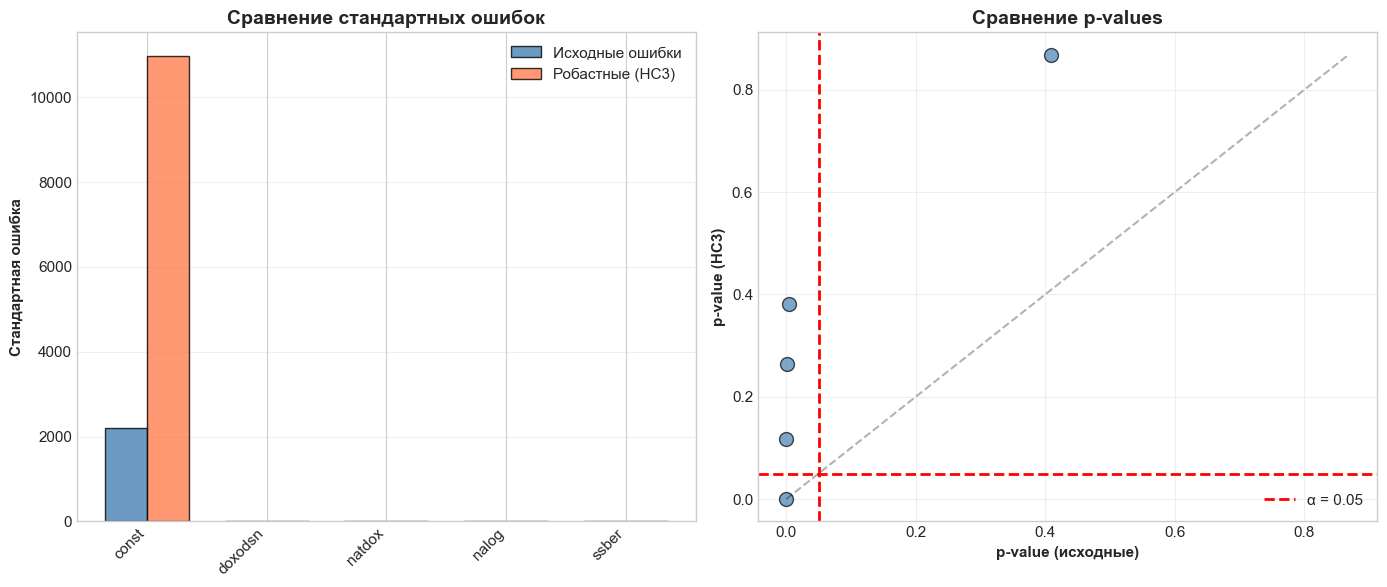


График сравнения поправки Уайта сохранен: white_correction_comparison.png
Таблица сравнения сохранена: white_correction_comparison.csv


In [47]:
print("""
Поправка Уайта (HC3 - Huber-White sandwich estimator):
    Корректирует стандартные ошибки коэффициентов
    Делает t-статистики и p-values надежными при гетероскедастичности
    НЕ меняет коэффициенты регрессии, только их стандартные ошибки

Типы поправок:
  HC0 - классическая поправка Уайта
  HC1 - поправка с малыми выборками
  HC3 - рекомендуется для малых выборок (используем эту)
""")

# Пересчет модели с поправкой Уайта
model_with_hc3 = best_model_obj.get_robustcov_results(cov_type='HC3')

print("\nСРАВНЕНИЕ: Исходные vs Робастные (HC3) стандартные ошибки")

# Сравнение коэффициентов и стандартных ошибок
comparison = pd.DataFrame({
    'Коэффициент': best_model_obj.params,
    'Ст.ош (исходн.)': best_model_obj.bse,
    'Ст.ош (HC3)': model_with_hc3.bse,
    't-stat (исходн.)': best_model_obj.tvalues,
    't-stat (HC3)': model_with_hc3.tvalues,
    'p-value (исходн.)': best_model_obj.pvalues,
    'p-value (HC3)': model_with_hc3.pvalues
})

print("\n", comparison.round(4))

# Визуализация изменения стандартных ошибок
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Стандартные ошибки
x_pos = np.arange(len(best_model_obj.params))
width = 0.35

axes[0].bar(x_pos - width/2, best_model_obj.bse, width, 
           label='Исходные ошибки', alpha=0.8, color='steelblue', edgecolor='black')
axes[0].bar(x_pos + width/2, model_with_hc3.bse, width, 
           label='Робастные (HC3)', alpha=0.8, color='coral', edgecolor='black')
axes[0].set_ylabel('Стандартная ошибка', fontweight='bold')
axes[0].set_title('Сравнение стандартных ошибок', fontweight='bold', fontsize=14)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(best_model_obj.params.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# p-values
axes[1].scatter(best_model_obj.pvalues, model_with_hc3.pvalues, s=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
axes[1].axvline(x=0.05, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('p-value (исходные)', fontweight='bold')
axes[1].set_ylabel('p-value (HC3)', fontweight='bold')
axes[1].set_title('Сравнение p-values', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Добавляем диагональ
min_val = min(best_model_obj.pvalues.min(), model_with_hc3.pvalues.min())
max_val = max(best_model_obj.pvalues.max(), model_with_hc3.pvalues.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='y=x')

plt.tight_layout()
plt.savefig('../results/figures/white_correction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафик сравнения поправки Уайта сохранен: white_correction_comparison.png")

# Сохранение таблицы сравнения
comparison.to_csv('../results/tables/white_correction_comparison.csv')
print("Таблица сравнения сохранена: white_correction_comparison.csv")

In [ ]:
# 11. ФИНАЛЬНАЯ МОДЕЛЬ С ПОПРАВКОЙ УАЙТА

In [48]:
print(model_with_hc3.summary())

                            OLS Regression Results                            
Dep. Variable:                 potras   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     56.53
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           8.61e-46
Time:                        23:23:01   Log-Likelihood:                -32280.
No. Observations:                2605   AIC:                         6.457e+04
Df Residuals:                    2600   BIC:                         6.460e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1816.6622    1.1e+04     -0.165      0.8

In [ ]:
# 12. ФИНАЛЬНОЕ СРАВНЕНИЕ: ИСХОДНАЯ vs УЛУЧШЕННАЯ МОДЕЛЬ


ИСХОДНАЯ МОДЕЛЬ (Модель 0 - BASELINE):
    Все переменные (6)
    Без логарифмирования
    Без поправок
    Точка отсчета для сравнения

ФИНАЛЬНАЯ МОДЕЛЬ:
    После пошагового отбора
    С логарифмированием (если применялось)
    С поправкой Уайта (если обнаружена гетероскедастичность)
    Улучшенная версия


ТАБЛИЦА СРАВНЕНИЯ:
     Метрика  Исходная модель  Финальная модель
          R²     5.566235e-01      5.561004e-01
     Adj. R²     5.555996e-01      5.554175e-01
         MSE     3.388766e+09      3.392764e+09
        RMSE     5.821310e+04      5.824744e+04
N переменных     6.000000e+00      4.000000e+00
         AIC     6.457009e+04      6.456916e+04
         BIC     6.461115e+04      6.459849e+04

ИЗМЕНЕНИЯ:
  ΔR²: -0.0005
  ΔMSE: +3998206.72 (+0.1%)
  Δ Переменных: -2


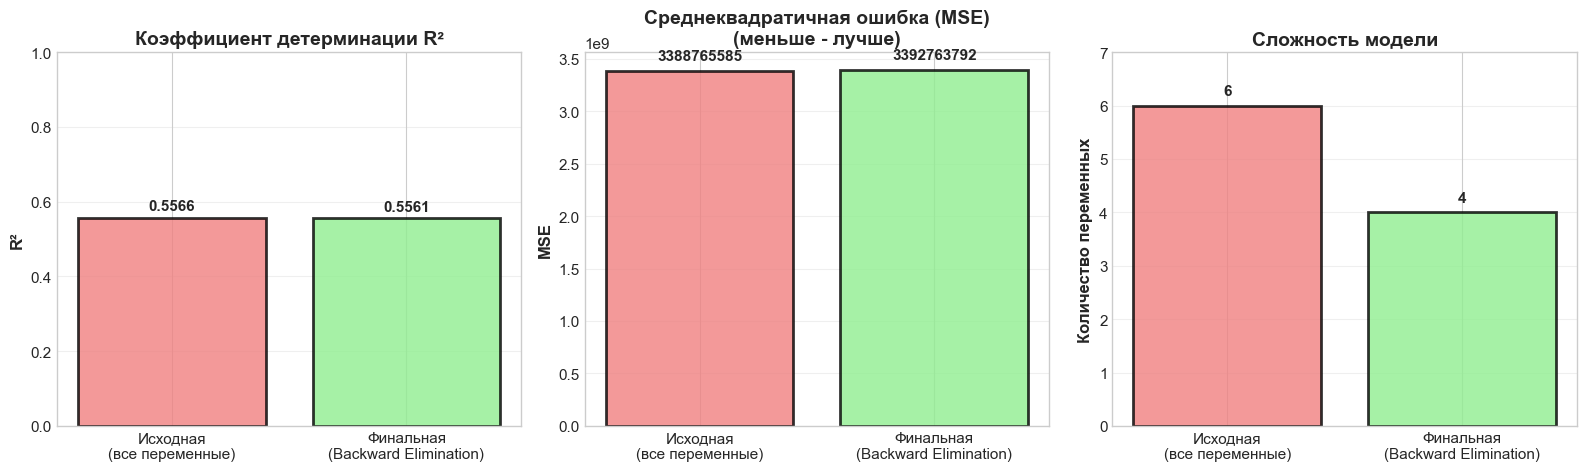


График финального сравнения сохранен: final_model_comparison.png
Таблица сравнения сохранена: final_model_comparison.csv


In [49]:
print(f"""
ИСХОДНАЯ МОДЕЛЬ (Модель 0 - BASELINE):
    Все переменные ({len(X_vars)})
    Без логарифмирования
    Без поправок
    Точка отсчета для сравнения

ФИНАЛЬНАЯ МОДЕЛЬ:
    После пошагового отбора
    С логарифмированием (если применялось)
    С поправкой Уайта (если обнаружена гетероскедастичность)
    Улучшенная версия
""")

# Расчет метрик для исходной модели
y_pred_baseline = model_0.fittedvalues
residuals_baseline = model_0.resid

# Расчет метрик для финальной модели
if best_model_name == 'log(Y) ~ X':
    y_pred_final = np.exp(best_model_obj.fittedvalues)
elif best_model_name == 'log(Y) ~ log(X)':
    y_pred_final = np.exp(best_model_obj.fittedvalues)
else:
    y_pred_final = best_model_obj.fittedvalues

mse_baseline = mean_squared_error(y, y_pred_baseline)
r2_baseline = r2_score(y, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

mse_final = mean_squared_error(y, y_pred_final)
r2_final = r2_score(y, y_pred_final)
rmse_final = np.sqrt(mse_final)

# Таблица сравнения
comparison_final = pd.DataFrame({
    'Метрика': ['R²', 'Adj. R²', 'MSE', 'RMSE', 'N переменных', 'AIC', 'BIC'],
    'Исходная модель': [
        model_0.rsquared,
        model_0.rsquared_adj,
        mse_baseline,
        rmse_baseline,
        len(X_vars),
        model_0.aic,
        model_0.bic
    ],
    'Финальная модель': [
        r2_final,
        best_model_obj.rsquared_adj,
        mse_final,
        rmse_final,
        len(model_vars),
        best_model_obj.aic,
        best_model_obj.bic
    ]
})

print("\nТАБЛИЦА СРАВНЕНИЯ:")
print(comparison_final.to_string(index=False))

# Расчет изменений
r2_diff = r2_final - r2_baseline
mse_diff = mse_final - mse_baseline
mse_pct_change = (mse_diff / mse_baseline) * 100

print("\nИЗМЕНЕНИЯ:")
print(f"  ΔR²: {r2_diff:+.4f}")
print(f"  ΔMSE: {mse_diff:+.2f} ({mse_pct_change:+.1f}%)")
print(f"  Δ Переменных: {len(model_vars) - len(X_vars):+d}")

# Визуализация сравнения
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models_names = ['Исходная\n(все переменные)', f'Финальная\n({best_model_name})']

# R²
axes[0].bar(models_names, [model_0.rsquared, r2_final], 
           color=['lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylabel('R²', fontweight='bold', fontsize=12)
axes[0].set_title('Коэффициент детерминации R²', fontweight='bold', fontsize=14)
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([model_0.rsquared, r2_final]):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

# MSE
axes[1].bar(models_names, [mse_baseline, mse_final], 
           color=['lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_ylabel('MSE', fontweight='bold', fontsize=12)
axes[1].set_title('Среднеквадратичная ошибка (MSE)\n(меньше - лучше)', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([mse_baseline, mse_final]):
    axes[1].text(i, v + 100000000, f'{v:.0f}', ha='center', fontweight='bold', fontsize=11)

# Количество переменных
axes[2].bar(models_names, [len(X_vars), len(model_vars)], 
           color=['lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Количество переменных', fontweight='bold', fontsize=12)
axes[2].set_title('Сложность модели', fontweight='bold', fontsize=14)
axes[2].set_ylim(0, len(X_vars) + 1)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate([len(X_vars), len(model_vars)]):
    axes[2].text(i, v + 0.2, f'{v}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/final_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nГрафик финального сравнения сохранен: final_model_comparison.png")

# Сохранение таблицы
comparison_final.to_csv('../results/tables/final_model_comparison.csv', index=False)
print("Таблица сравнения сохранена: final_model_comparison.csv")

In [ ]:
# 13. ИТОГОВЫЕ ВЫВОДЫ

In [50]:
print(f"""
РЕЗУЛЬТАТЫ АНАЛИЗА:

1. ВЫБОР ЛУЧШЕЙ МОДЕЛИ:
   Лучшая модель: {best_model_name}
   
2. ХАРАКТЕРИСТИКИ ЛУЧШЕЙ МОДЕЛИ:
     R² = {r2_final:.4f} (объясняет {r2_final*100:.2f}% вариации Y)
     MSE = {mse_final:.2f}
     Количество переменных: {len(model_vars)}
   
3. ГЕТЕРОСКЕДАСТИЧНОСТЬ:
     Тест Бройша-Пагана: p-value = {bp_test[1]:.4f} {'(гетероскедастичность обнаружена)' if bp_test[1] < 0.05 else '(гетероскедастичность не обнаружена)'}
     Тест Уайта: p-value = {white_test[1]:.4f} {'(гетероскедастичность обнаружена)' if white_test[1] < 0.05 else '(гетероскедастичность не обнаружена)'}

4. ПОПРАВКА УАЙТА:
   {'Применена поправка HC3 для коррекции стандартных ошибок' if has_heteroscedasticity or has_heteroscedasticity_white else 'Поправка не требуется (гетероскедастичность не обнаружена)'}
   
5. ФИНАЛЬНОЕ СРАВНЕНИЕ (исходная vs финальная модель):
     Изменение R²: {r2_diff:+.4f}
     Изменение MSE: {mse_diff:+.2f} ({mse_pct_change:+.1f}%)
     Уменьшение переменных: {len(X_vars) - len(model_vars)} (с {len(X_vars)} до {len(model_vars)})
""")

print("\nОЦЕНКА КАЧЕСТВА УЛУЧШЕНИЯ:")

if mse_diff < 0:
    print(f"MSE УЛУЧШЕНА (снижение на {abs(mse_pct_change):.1f}%)")
else:
    print(f"MSE УХУДШЕНА (увеличение на {mse_pct_change:.1f}%)")

if r2_diff > -0.05:  # Допустимое падение R² на 5%
    print(f"R² находится на приемлемом уровне (изменение {r2_diff:+.4f})")
else:
    print(f"R² значительно снижена (изменение {r2_diff:+.4f})")

if mse_diff < 0 and r2_diff > -0.05:
    print(f"\nФИНАЛЬНАЯ МОДЕЛЬ УЛУЧШЕНА!")
    print(f"Лучше по MSE, приемлемые потери в R²")

elif mse_diff < 0 and r2_diff <= -0.05:
    print(f"\nФИНАЛЬНАЯ МОДЕЛЬ УЛУЧШЕНА ПО MSE")
    print(f"но со значительными потерями в R²")
else:
    print(f"\nФИНАЛЬНАЯ МОДЕЛЬ НЕ УЛУЧШЕНА")

# Сохранение финальных результатов
summary_results = {
    'best_model_name': best_model_name,
    'best_model_obj': best_model_obj,
    'model_with_hc3': model_with_hc3,
    'model_0': model_0,
    'y_pred_final': y_pred_final,
    'residuals': residuals,
    'mse_baseline': mse_baseline,
    'mse_final': mse_final,
    'r2_baseline': r2_baseline,
    'r2_final': r2_final
}

print("\nВсе результаты сохранены в папке results/")


РЕЗУЛЬТАТЫ АНАЛИЗА:

1. ВЫБОР ЛУЧШЕЙ МОДЕЛИ:
   Лучшая модель: Backward Elimination

2. ХАРАКТЕРИСТИКИ ЛУЧШЕЙ МОДЕЛИ:
     R² = 0.5561 (объясняет 55.61% вариации Y)
     MSE = 3392763791.63
     Количество переменных: 4

3. ГЕТЕРОСКЕДАСТИЧНОСТЬ:
     Тест Бройша-Пагана: p-value = 0.0000 (гетероскедастичность обнаружена)
     Тест Уайта: p-value = 0.0000 (гетероскедастичность обнаружена)

4. ПОПРАВКА УАЙТА:
   Применена поправка HC3 для коррекции стандартных ошибок

5. ФИНАЛЬНОЕ СРАВНЕНИЕ (исходная vs финальная модель):
     Изменение R²: -0.0005
     Изменение MSE: +3998206.72 (+0.1%)
     Уменьшение переменных: 2 (с 6 до 4)


ОЦЕНКА КАЧЕСТВА УЛУЧШЕНИЯ:
MSE УХУДШЕНА (увеличение на 0.1%)
R² находится на приемлемом уровне (изменение -0.0005)

ФИНАЛЬНАЯ МОДЕЛЬ НЕ УЛУЧШЕНА

Все результаты сохранены в папке results/
